# Data cleaning


Use **Code** cells to write and run any code you need to answer the question and **Markdown** cells to write out answers in words. After you are finished with the assignment, remember to download it as an **HTML file** and submit it in **ELMS**.

In [50]:
from requests import get
import re
import numpy as np 
import pandas as pd 

The following sections will look at some strategies for cleaning real world data. We'll use some selected variables from the 2024 round of the <a href="https://electionstudies.org/data-center/2024-time-series-study/">American National Election Study</a> which surveys eligible voters before and after each presidential election.

This subset of the data contains the following variables: 


| variable          | description                                                   |
|-------------------|---------------------------------------------------------------|
| id                | Person ID                                                     |
| age               | Age                                                           |
| age_group         | Age (5 categories)                                            |
| gender            | Gender                                                        |
| race              | Race                                                          |
| education         | Highest level of education achieved (5-category)              |
| partyid           | Party ID (7 category)                                         |
| libcon            | 7pt scale liberal-conservative self-placement                 |
| fo_dei            |  Approve/disapprove Diversity,   Equity, and Inclusion (DEI)  |
| fo_jus_soli       | Favor or oppose ending birthright citizenship                 |
| fo_ukraine_mil    | Favor/oppose U.S. giving weapons to help Ukraine fight Russia |
| fo_israel_mil     | Favor/oppose U.S. giving military assistance to Israel        |
| fo_reduce_unequal | Favor/oppose government trying to reduce income inequality    |
| fo_schoolvax      | Favor/oppose requiring vaccines in schools                    |
| fo_trans_mil      | Favor/oppose transgender people serve in military             |
| harris_likes      | Open ended: what does R like about Kamala Harris?             |
| harris_dislikes   | Open ended: what does R dislike about Kamala Harris?          |
| trump_likes       | Open ended: what does R like about Donald Trump?              |
| trump_dislikes    | Open ended: what does R dislike about Donald Trump?           |
| mipp_1            | Open ended: most important problem facing the country         |
| harris_therm      | 0 to 100 scale: feelings towards Kamala Harris                |
| trump_therm       | 0 to 100 scale: feelings towards Donald Trump                 |

<div class="alert alert-block alert-info">
        <b>Note:</b> Ordinarily, we would want to use weighting to make the results from this survey more closely resemble the U.S. adult population. I've left these out for the sake simplicity, but keep in mind that any statistics we calculate here may be a bit skewed by their omission.
    </div>

In [51]:
data_file = "anes24_sample.csv"
df = pd.read_csv(data_file)
df.head()

,id,age,age_group,gender,race,education,partyid,libcon,fo_dei,fo_jus_soli,...,fo_reduce_unequal,fo_schoolvax,fo_trans_mil,harris_likes,harris_dislikes,trump_likes,trump_dislikes,mipp_1,harris_therm,trump_therm
0,140001,50,45-54,1. Man,3. Hispanic,4. Bachelor's degree,7. Strong Republican,6. Conservative,7. Oppose a great deal,6. Oppose moderately,...,7. Oppose a great deal,7. Oppose a great deal,4. Neither favor nor oppose,NaN,She has had 3 1/2 yrs to make things better an...,look at the cost of everything I stated before...,NaN,immigration we can't take care of our own peop...,0.0,85.0
1,140002,41,35-44,2. Woman,4. Asian or Native Hawaiian/other Pacific Isla...,"3. Some post-high school, no bachelor's degree",4. Independent,4. Moderate; middle of the road,4. Neither favor nor oppose,4. Neither favor nor oppose,...,2. Favor a moderate amount,1. Favor a great deal,4. Neither favor nor oppose,NaN,NaN,NaN,NaN,"The cost of everything, people can not afford ...",50.0,50.0
2,140003,44,35-44,2. Woman,"1. White, non-Hispanic","3. Some post-high school, no bachelor's degree",1. Strong Democrat,2. Liberal,4. Neither favor nor oppose,7. Oppose a great deal,...,2. Favor a moderate amount,1. Favor a great deal,1. Favor a great deal,She is a woman who advocates for reproductive ...,NaN,NaN,I disagree with him on literally EVERYTHING. H...,threats to democracy,85.0,0.0
3,140004,45,45-54,1. Man,4. Asian or Native Hawaiian/other Pacific Isla...,"3. Some post-high school, no bachelor's degree",6. Not very strong Republican,99. Haven't thought much about this,6. Oppose a moderate amount,6. Oppose moderately,...,4. Neither favor nor oppose,1. Favor a great deal,4. Neither favor nor oppose,NaN,NaN,strong personality,NaN,economy and leadership.,85.0,NaN
4,140005,80,NaN,1. Man,"1. White, non-Hispanic",5. Graduate degree,5. Independent-Republican,4. Moderate; middle of the road,6. Oppose a moderate amount,2. Favor moderately,...,4. Neither favor nor oppose,7. Oppose a great deal,7. Oppose a great deal,NaN,"Economy, border security, killing private insu...","economy, border security, keep my insurance, g...","bio weapon injections, spending,","Economy, Border,",0.0,60.0


The first thing you might notice here is that many of the responses have `NaN`, which indicates missing or invalid responses. This is pretty common with survey data: some questions aren't asked because they're not relevant to all respondents, or respondents might hang up the phone, or just refuse to give a valid answer.

You can get a sense of the number of `NaN` values using the `.info` method: 

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5521 non-null   int64  
 1   age                5521 non-null   int64  
 2   age_group          3651 non-null   object 
 3   gender             5521 non-null   object 
 4   race               5521 non-null   object 
 5   education          5521 non-null   object 
 6   partyid            5521 non-null   object 
 7   libcon             5521 non-null   object 
 8   fo_dei             5521 non-null   object 
 9   fo_jus_soli        5521 non-null   object 
 10  fo_ukraine_mil     5521 non-null   object 
 11  fo_israel_mil      5521 non-null   object 
 12  fo_reduce_unequal  5521 non-null   object 
 13  fo_schoolvax       5521 non-null   object 
 14  fo_trans_mil       5521 non-null   object 
 15  harris_likes       2581 non-null   object 
 16  harris_dislikes    2428 

Alternatively, using `isnull()` gives us a data frame of the same size with `True` and `False` values depending on whether it was a missing value or not. Then, `mean()` calculates the arithmetic mean for each column. Since Python treats `True` as `1` and `False` as `0`, the mean of all of these values is the same as the proportion of missing data for each column:

In [53]:
df.isnull().mean()

id                   0.000000
age                  0.000000
age_group            0.338707
gender               0.000000
race                 0.000000
education            0.000000
partyid              0.000000
libcon               0.000000
fo_dei               0.000000
fo_jus_soli          0.000000
fo_ukraine_mil       0.000000
fo_israel_mil        0.000000
fo_reduce_unequal    0.000000
fo_schoolvax         0.000000
fo_trans_mil         0.000000
harris_likes         0.532512
harris_dislikes      0.560225
trump_likes          0.565115
trump_dislikes       0.404818
mipp_1               0.104329
harris_therm         0.115197
trump_therm          0.114834
dtype: float64

<font color ='red'>**Question 1: the "like/dislikes" questions were left blank if a respondent said they couldn't identify anything they liked about a candidate. How would you show the relationship between party ID and being able to say anything positive about Trump?**</font>

In [54]:
df['no_trump_likes'] = df['trump_likes'].isnull()

pd.crosstab(index = df['partyid'], 
            columns = df['no_trump_likes'],
            normalize='index')

no_trump_likes,False,True
partyid,,
-4. Error,0.000000,1.000000
-8. Don't know,0.000000,1.000000
-9. Refused,0.129032,0.870968
1. Strong Democrat,0.078387,0.921613
2. Not very strong Democrat,0.181818,0.818182
3. Independent-Democrat,0.175070,0.824930
4. Independent,0.321053,0.678947
5. Independent-Republican,0.763966,0.236034
6. Not very strong Republican,0.684575,0.315425


You might notice that there were no `NaN` values reported for the `partyid` and `libcon` variables, but, in reality, there are still non-responses for these questions, they're just given text labels instead of being left blank. We can see this by using the `value_counts` method. 

(note: we can use the `sort_index` method to sort these alphabetically instead of in order of the most frequent category. For ordinal variables like this one that have a clear ordering, that may often be a better option, but we'll look at an even more flexible way to handle this kind of data in the next section)

In [55]:
df.partyid.value_counts().sort_index()

-4. Error                           2
-8. Don't know                      5
-9. Refused                        31
1. Strong Democrat               1314
2. Not very strong Democrat       616
3. Independent-Democrat           714
4. Independent                    380
5. Independent-Republican         716
6. Not very strong Republican     577
7. Strong Republican             1166
Name: partyid, dtype: int64

In [56]:
df.libcon.value_counts().sort_index()

-4. Error                                 3
-9. Refused                              67
1. Extremely liberal                    250
2. Liberal                              819
3. Slightly liberal                     543
4. Moderate; middle of the road        1187
5. Slightly conservative                594
6. Conservative                        1030
7. Extremely conservative               309
99. Haven't thought much about this     719
Name: libcon, dtype: int64

In many cases, we will want to convert this kind of labelled missing data to an explicit `NaN` instead. This will prevent these responses from showing up in our tables and graphs. We can replace a value with an `NaN` like the `replace` function:

In [57]:
missing_values = ["-9. Refused", '-4. Error', "99. Haven't thought much about this", "-8. Don't know"]

df['libcon_replaced'] = df['libcon'].replace(missing_values, np.nan)

Now check the results:

In [58]:
df.libcon_replaced.value_counts().sort_index(ascending=True)

1. Extremely liberal                250
2. Liberal                          819
3. Slightly liberal                 543
4. Moderate; middle of the road    1187
5. Slightly conservative            594
6. Conservative                    1030
7. Extremely conservative           309
Name: libcon_replaced, dtype: int64

<font color ='red'>**Question 2: Replace the refused/don't know values in the party ID variable with `NaN`**</font>

In [59]:
df['partyid'] = df['partyid'].replace(missing_values, np.nan)
df['partyid'].value_counts()

1. Strong Democrat               1314
7. Strong Republican             1166
5. Independent-Republican         716
3. Independent-Democrat           714
2. Not very strong Democrat       616
6. Not very strong Republican     577
4. Independent                    380
Name: partyid, dtype: int64

In [60]:
# when you're done, re-run the function to count nulls to make sure your code worked:
df.isnull().mean()


id                   0.000000
age                  0.000000
age_group            0.338707
gender               0.000000
race                 0.000000
education            0.000000
partyid              0.006883
libcon               0.000000
fo_dei               0.000000
fo_jus_soli          0.000000
fo_ukraine_mil       0.000000
fo_israel_mil        0.000000
fo_reduce_unequal    0.000000
fo_schoolvax         0.000000
fo_trans_mil         0.000000
harris_likes         0.532512
harris_dislikes      0.560225
trump_likes          0.565115
trump_dislikes       0.404818
mipp_1               0.104329
harris_therm         0.115197
trump_therm          0.114834
no_trump_likes       0.000000
libcon_replaced      0.142909
dtype: float64

### Recoding data

In some cases it can make sense to collapse or rearrange one or more categories to simplify our data or capture a particular subset of respondents.  For instance, "independents" who lean towards on party or another are often more similar to regular partisans than they are to independents who don't lean either direction:


In [61]:
df.pivot_table(values=['harris_therm','trump_therm'], 
               index = 'partyid',
               aggfunc = 'mean'
               )

,harris_therm,trump_therm
partyid,,
1. Strong Democrat,83.925125,7.300752
2. Not very strong Democrat,70.251366,15.400000
3. Independent-Democrat,66.360502,15.690852
4. Independent,38.623003,41.072327
5. Independent-Republican,22.574163,66.448657
6. Not very strong Republican,25.252988,65.708583
7. Strong Republican,9.273521,87.435453


...so for the sake of simplify we sometimes collapse these categories into "Democrats", "Independents" and "Republicans". 

When we want to take an existing variable and combine responses to create something new, we can use the `map` method to apply a dictionary object that will re-map our original values onto new ones. The dictionary should take the form of `{[oldvalue]:[newvalue]}`

In [62]:
partyid_map = {"1. Strong Democrat": "Democrat",
               "2. Not very strong Democrat": "Democrat",
               "3. Independent-Democrat": "Democrat",
               "4. Independent": "Independent", 
               "5. Independent-Republican": "Republican",
               "6. Not very strong Republican": "Republican",
               "7. Strong Republican": "Republican"
}

# using the assign function to create a new variable:
df['partyid_3cat'] = df['partyid'].map(partyid_map)

# viewing the results
df.partyid_3cat.value_counts()

Democrat       2644
Republican     2459
Independent     380
Name: partyid_3cat, dtype: int64

You'll notice that the results here are sorted with Democrats, Republicans and then Independents. For the purposes of making a plot or table, that ordering might not make a lot of sense. In many cases, alphabetizing these categories with `sort_index` won't make much sense either. Fortunately, Pandas has a special "categorical" data type that can give us more fine-grained control over this kind of variable.

<AxesSubplot: >

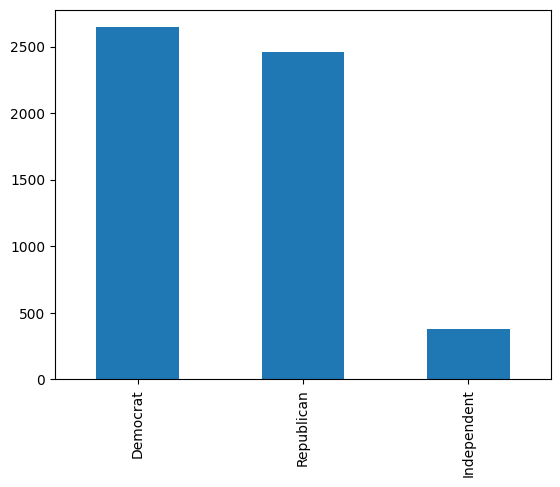

In [63]:
df.partyid_3cat.value_counts().plot.bar()

You can convert a string column to categorical using `astype('category)`:

In [64]:
df['partyid_3cat']  = df.partyid_3cat.astype('category')

df['partyid_3cat'].value_counts()


Democrat       2644
Republican     2459
Independent     380
Name: partyid_3cat, dtype: int64

Once we have a categorical variable, we can use `cat.reorder_categories` to create a fixed ordering for our categorical variables:

In [65]:
df['partyid_3cat'] = df['partyid_3cat'].cat.reorder_categories([ 'Democrat', "Independent", "Republican"], ordered=True)

Once we've done this, using `value_counts` with `sort_index` will always sort the data in the order specified by `reorder_categories`:

<AxesSubplot: >

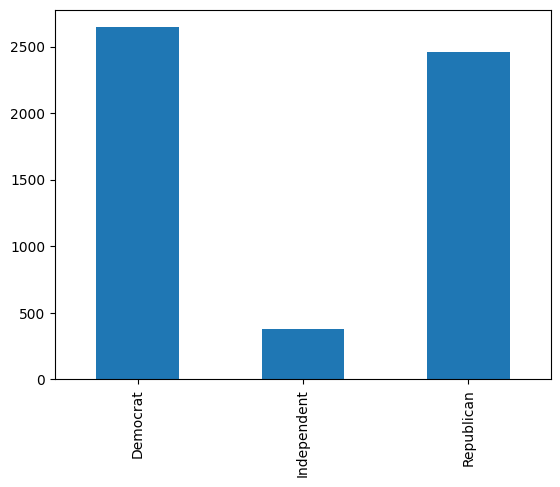

In [66]:
df.partyid_3cat.value_counts().sort_index().plot.bar()

Since recoding is easy to mess up, I think its always a good idea to always:
1. Preserve the old variable and give your new variable a different name
2. Check your results by comparing the old variable to the new one.

You can check your results by selecting the old values and the new values, dropping duplicates, and then checking to see how the unique labels match up:

In [67]:
df[['partyid', 'partyid_3cat']].drop_duplicates().sort_values('partyid')

,partyid,partyid_3cat
2,1. Strong Democrat,Democrat
10,2. Not very strong Democrat,Democrat
5,3. Independent-Democrat,Democrat
1,4. Independent,Independent
4,5. Independent-Republican,Republican
3,6. Not very strong Republican,Republican
0,7. Strong Republican,Republican
113,NaN,NaN


In some cases, you might have several variables that have the same set of response options, in which case it might be convenient to apply the same categorical ordering to all of them. One way you can do this is by creating a separate `categoricalDtype` and then applying it to multiple variables in a loop. For instance, all of the variables whose names start with `fo_` come from questions asking whether the respondent favors or opposes a particular policy:

In [68]:
df.loc[:, df.columns.str.startswith("fo_")]

,fo_dei,fo_jus_soli,fo_ukraine_mil,fo_israel_mil,fo_reduce_unequal,fo_schoolvax,fo_trans_mil
0,7. Oppose a great deal,6. Oppose moderately,1. Favor a great deal,1. Favor a great deal,7. Oppose a great deal,7. Oppose a great deal,4. Neither favor nor oppose
1,4. Neither favor nor oppose,4. Neither favor nor oppose,4. Neither favor nor oppose,4. Neither favor nor oppose,2. Favor a moderate amount,1. Favor a great deal,4. Neither favor nor oppose
2,4. Neither favor nor oppose,7. Oppose a great deal,1. Favor a great deal,7. Oppose a great deal,2. Favor a moderate amount,1. Favor a great deal,1. Favor a great deal
3,6. Oppose a moderate amount,6. Oppose moderately,6. Oppose moderately,7. Oppose a great deal,4. Neither favor nor oppose,1. Favor a great deal,4. Neither favor nor oppose
4,6. Oppose a moderate amount,2. Favor moderately,4. Neither favor nor oppose,6. Oppose moderately,4. Neither favor nor oppose,7. Oppose a great deal,7. Oppose a great deal
...,...,...,...,...,...,...,...
5516,4. Neither favor nor oppose,4. Neither favor nor oppose,4. Neither favor nor oppose,7. Oppose a great deal,-6. No post interview,-6. No post interview,-6. No post interview
5517,4. Neither favor nor oppose,4. Neither favor nor oppose,2. Favor moderately,2. Favor moderately,4. Neither favor nor oppose,1. Favor a great deal,2. Favor a moderate amount
5518,2. Favor a moderate amount,7. Oppose a great deal,4. Neither favor nor oppose,4. Neither favor nor oppose,-6. No post interview,-6. No post interview,-6. No post interview
5519,1. Favor a great deal,7. Oppose a great deal,4. Neither favor nor oppose,7. Oppose a great deal,1. Favor a great deal,1. Favor a great deal,1. Favor a great deal


If we wanted to give all of these variables a short hand label, we might do something like this:

In [69]:
favor_oppose = {'1. Favor a great deal': 'Favor', 
                '2. Favor a moderate amount' : 'Favor', 
                '2. Favor moderately' : 'Favor', 
                '3. Favor a little' : 'Favor', 
                '4. Neither favor nor oppose' : 'Neither', 
                '5. Oppose a little': 'Oppose', 
                '6. Oppose a moderate amount' : 'Oppose',
                '6. Oppose moderately' : 'Oppose',
                '7. Oppose a great deal' :'Oppose'
}
fo_categories = pd.CategoricalDtype(categories=['Oppose', "Neither", "Favor"], ordered=True)



In [70]:
renamed_fo = df.loc[:, df.columns.str.startswith("fo_")].apply(lambda x: x.map(favor_oppose).astype(fo_categories))
renamed_fo

,fo_dei,fo_jus_soli,fo_ukraine_mil,fo_israel_mil,fo_reduce_unequal,fo_schoolvax,fo_trans_mil
0,Oppose,Oppose,Favor,Favor,Oppose,Oppose,Neither
1,Neither,Neither,Neither,Neither,Favor,Favor,Neither
2,Neither,Oppose,Favor,Oppose,Favor,Favor,Favor
3,Oppose,Oppose,Oppose,Oppose,Neither,Favor,Neither
4,Oppose,Favor,Neither,Oppose,Neither,Oppose,Oppose
...,...,...,...,...,...,...,...
5516,Neither,Neither,Neither,Oppose,NaN,NaN,NaN
5517,Neither,Neither,Favor,Favor,Neither,Favor,Favor
5518,Favor,Oppose,Neither,Neither,NaN,NaN,NaN
5519,Favor,Oppose,Neither,Oppose,Favor,Favor,Favor


In [71]:
crosstab = pd.crosstab(
    index =  renamed_fo['fo_ukraine_mil'],
    columns = renamed_fo['fo_israel_mil'],
    normalize='index',
    rownames = ['Favor/Oppose Ukraine military aid'],
    colnames = ['Favor/Oppose Israel military aid']
            )

ct = (crosstab * 100).round(1).astype(str) + '%'
ct

Favor/Oppose Israel military aid,Oppose,Neither,Favor
Favor/Oppose Ukraine military aid,,,
Oppose,51.9%,13.3%,34.8%
Neither,11.2%,64.9%,23.8%
Favor,23.0%,21.9%,55.1%


In [72]:
crosstab = pd.crosstab(index =  renamed_fo['fo_dei'],
            columns = df['partyid_3cat'],
            normalize='columns',
            rownames = ['Favor/Oppose DEI'],
            colnames = ['Party ID']
            )

ct = (crosstab * 100).round(1).astype(str) + '%'
ct

Party ID,Democrat,Independent,Republican
Favor/Oppose DEI,,,
Oppose,10.1%,21.5%,56.0%
Neither,37.1%,60.7%,33.4%
Favor,52.8%,17.8%,10.6%


### Dropping missing data

In some cases, we will want to just drop rows that have missing data, we can use this with the Pandas `.dropna()` method. `axis=1` will drop columns with missing information:

In [73]:
df_no_missing_cols = df.dropna(axis = 1)
df_no_missing_cols.shape

(5521, 14)

`axis=0` will drop all rows with missing information:

In [74]:
df_no_missing_rows = df.dropna(axis = 0) 
df_no_missing_rows.shape

(171, 25)

We want to be careful here: surveys like the ANES will rarely ask every respondent to answer every single question, and some respondents will invariably skip or refuse to answer certain items. If we drop any rows with any missing data, we end up tossing out a huge amount of information: from 8280 responses to just 312. This is probably not a great idea. So more often we'll want only drop rows when some crucial bit of information is missing. For instance, we could do something like this to only drop rows where the `age_group` and `partyid_3cat` variables are missing:

In [75]:
df_no_missing_pid_or_age = df.dropna(axis=0, subset=["partyid_3cat", "age_group"])

df_no_missing_pid_or_age.shape

(3632, 25)

Or we could only drop cases where there is non-missing data for at least twenty questions:

In [76]:
df_min_2 = df.dropna(thresh=20, axis=0)

df_min_2.shape

(5136, 25)

As with the previous examples, you should always be careful to avoid throwing out useful data if possible. 

## String Data

String data and needing to clean up string data are very common in social science research. Whether it's coding open response questions in surveys or parsing social media posts, lots of data in the social sciences are text data, and it's important to understand how to deal with them. This is particularly true when using web scraping techniques. The data that you get from web scraping will generally at least start out as string data, which you can then transform into numerical variables as needed.



### Regular Expressions

A **regular expression, or regex**, is a sequence of characters that are used to match patterns within text. These can be extremely useful for searching and matching complicated string patterns. Regexes use specific rules and formatting guidelines to specify various patterns and are implemented in Python via the `re` package. Let's take a look at a quick example.

In [77]:
text = 'this is some text'
re.split(r"\s+", text)

['this', 'is', 'some', 'text']

The regular expression `\s+` refers to one of more whitespace characters. This uses `\s` as the regex formatting for a whitespace character, as well as the `+` to indicate one or more. Note that `\s` is used because `s` by itself would refer to the letter `s`. The backslash `\` is an escape character that allows Python to interpret it as a pattern that it is trying to match.

We could have done this without the `+` but that would try to separate on individual spaces instead. In the above example, there would be no difference, but if we were to add additional spaces, we'd see a big change.

In [78]:
text = 'this is some    text'
re.split(r"\s", text)

['this', 'is', 'some', '', '', '', 'text']

You can also first compile a regular expression, then use it multiple times. 

In [79]:
regex = re.compile(r"\s+")
regex.split(text)

['this', 'is', 'some', 'text']

In [80]:
regex.split('some other  text')

['some', 'other', 'text']

Other regex functions, like `findall` can be used to extract bits of text that matches some pattern. This is an example of a pattern that could be used to identify and capture a price from a string of text.

In [81]:
text = "33lbs of bananas cost $90.00" 

re.findall(r"(\$[0-9]+[\.0-9]{0,2})", text)

['$90.0']

### Regex methods

|Method|Description|
|-|-|
|`findall`|Return all nonoverlapping matching patterns in a string as a list|
|`match`|Match pattern at start of string and optionally segment pattern components into groups; if the pattern matches, return a match object, and otherwise None|
|`search`|Scan string for match to pattern, returning a match object if so; unlike match, the match can be anywhere in the string as opposed to only at the beginning|
|`split`|Break string into pieces at each occurrence of pattern|
|`sub`|Replace all occurrences of pattern in string with replacement expression|

### Working with regex

Unless you work with regular expressions frequently, it will be very hard to get good enough at regex to write it out on the fly. Most of the time, you only need regex occasionally for one or two tasks, and it can be hard to remember what all of the patterns and syntax are. **You do not need to try to memorize all of the regex syntax!** There are plenty of tools available to help you out whenever you need to come back to it. Understanding some of the basics should help you get started, and you can use existing cheatsheets as well as online regex builder tools to do the rest. 

Regex 101 (https://regex101.com) is a website that helps you build your regexes. This website allows you to paste in the text you want to search, as well as type in a regex that you want to build. The text selected by the regex will be highlighted as you go, helping you build the exact regex that you need to get what you want. 

### Regex Cheatsheet

There's a regex cheatsheet in this folder that you can use as a reference (its also downloadable through ELMS)

## Strings in DataFrames

Many times, we'll have to work with strings that are in DataFrames. These are a bit trickier than individual strings, because we want to be efficient about how we do this. Luckily for us, the creators of the pandas DataFrames recognized that string manipulation would be fairly common and included tools to help make it easier.


We can use the `extract` method to capture text that fits a regex pattern. The parentheses in the expression below are the "capture group" for our regex, this is the part of the pattern that we want to extract, so the code below will extract the portion of the text that matches the string "liberal", "conservative", or "moderate", so this is a way to recode the `libcon` variable to a 3-category measure without using the `map` function:


In [82]:
df['libcon'].value_counts().sort_index()

-4. Error                                 3
-9. Refused                              67
1. Extremely liberal                    250
2. Liberal                              819
3. Slightly liberal                     543
4. Moderate; middle of the road        1187
5. Slightly conservative                594
6. Conservative                        1030
7. Extremely conservative               309
99. Haven't thought much about this     719
Name: libcon, dtype: int64

In [83]:
# first lower case, then match: 
libcon_lowercase = df.libcon.str.lower()

df['libcon_3cat'] = libcon_lowercase.str.extract('(liberal|conservative|moderate)')

df['libcon_3cat'].value_counts()

conservative    1933
liberal         1612
moderate        1187
Name: libcon_3cat, dtype: int64

We can compare our new variables against the old ones like this: 

In [84]:
df[['libcon', 'libcon_3cat']].drop_duplicates().sort_values('libcon')

,libcon,libcon_3cat
2658,-4. Error,NaN
98,-9. Refused,NaN
30,1. Extremely liberal,liberal
2,2. Liberal,liberal
14,3. Slightly liberal,liberal
1,4. Moderate; middle of the road,moderate
11,5. Slightly conservative,conservative
0,6. Conservative,conservative
33,7. Extremely conservative,conservative
3,99. Haven't thought much about this,NaN


`str.contains` returns a `True` if the string contains the pattern given as its argument and `False` otherwise. One use for the `contains` function is to identify cases where a piece of text shows up so that you can filter or count the number of occurrences of that string. So if we wanted to know how many people mentioned climate change or global warming in their response to the "most important political problem" question, we could use a regular expression like `"climate change|global warming"` to count these cases:

In [85]:
# df.assign() does the same thing as df['colname'] = ... 
df =df.assign(climate_change = df['mipp_1'].str.contains('climate change|global warming',
                                                         case=False, regex=True))

# get the proportion who mentioned this: 
df.climate_change.mean()


0.023255813953488372

Then we can use this indicator to get the average proportion of people giving this response across different levels of some variable like party ID:

In [86]:
df.pivot_table(index='partyid_3cat', values='climate_change', aggfunc='mean')
# or : 
# df.groupby('partyid_3cat')['climate_change'].mean()

,climate_change
partyid_3cat,
Democrat,0.043983
Independent,0.006211
Republican,0.003205


<font color ='red'>**Question 3: How would I show the relationship between `age_group` and the likelihood of mentioning issues related to gun-violence as a response to the `mipp_1` question? What about issues related to abortion rights? Can you write your expression in a way that allows you to capture differences in spelling or punctuation?**</font>

In [87]:
df['guns'] = df['mipp_1'].str.contains(r'\bgun|assault weapon|shooting',
                                                         case=False, regex=True)

# get the proportion who mentioned this: 
df.groupby('age_group').guns.mean()

age_group
18-24    0.026316
25-34    0.027553
35-44    0.025579
45-54    0.018006
55-64    0.015990
65+      0.021277
Name: guns, dtype: float64

In [89]:
df['abortion'] = df['mipp_1'].str.contains(r'abortion|\broe\b',
                                       case=False, regex=True)

# get the proportion who mentioned this: 
df.groupby('age_group').abortion.mean()

age_group
18-24    0.031579
25-34    0.035656
35-44    0.017052
45-54    0.019391
55-64    0.014760
65+      0.000000
Name: abortion, dtype: float64

Another common use for the `str.contains` function is to subset a data set. Since it returns a boolean value, we can use it with `.loc` to get rows where a pattern is matched. For instance, here's how I would get a data frame containing only people who mentioned age, dementia, or cognitive ability in their reasons for disliking Donald Trump. (the `\b` in this expression represents a word boundary, so this avoids capturing terms that just happen to begin or end with "age" like "baggage", or "mortgage". 

In [40]:
df_age = df.loc[df.trump_dislikes.str.contains(r'\bold\b|\bage\b|dementia|cogniti*',
                                               case=False,
                                               na=False)]

# how many rows?
df_age.shape[0]

105

<font color ='red'>**Question 4: How many Democrats mentioned Donald Trump when asked to name a thing they liked about Kamala Harris? How many Republicans mentioned Kamala Harris when asked to list something they liked about Trump?**</font>

In [120]:
df['mentioned_trump'] = df['harris_likes'].str.contains('Trump', na=False) # na = False ensures that non-responses are coded as "false" here
df['mentioned_harris'] = df['trump_likes'].str.contains('Harris', na=False)

In [121]:
df['mentioned_harris'][df.partyid_3cat == "Republican"].sum()



42

In [122]:
df['mentioned_trump'][df.partyid_3cat == "Democrat"].sum()


376